# Data Science: Performance of Pure Python vs Pandas vs Numpy

## 01. Intro & Imports

Data Science: Performance of Pure Python vs Pandas vs Numpy Notebook

In this notebook we will compare data processing speed of pure Python, Pandas and Numpy

* Notebook @author Lukasz KM, lucas.mlexp@gmail.com, http://machinelearningexp.com
* Notebook License: Creative Commons CC-BY-SA https://creativecommons.org/licenses/by-sa/4.0/

In [1]:
# Python 3.6
import os
import sys
import gc
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 02. Prepare dummy random dataset

In [2]:
# We will prepare artificial dataset that contains orders of the product.
# Each order will have random number of items ordered and random price within given range
dataset_python = []
range_products = [1,10000] # number of products in the dataset
range_orders = [1,20] # range of orders for product from which to select one random value
range_quantity = [1,100] # range of quantity in order from which to select one random value
range_price = [0.1,50.00] # range of product prices from which to select one random value

In [3]:
def generate_dummy_dataset(range_products,range_orders,products_quantity,products_price):
    generated_dataset = []
    for idx in range(range_products[0],range_products[1]):
        random_orders = random.randint(range_orders[0],range_orders[1]) 
        for odx in range(random_orders):
            quantity = random.randint(range_quantity[0],range_quantity[1])
            price = random.uniform(range_price[0],range_price[1])
            generated_dataset.append([idx,odx,quantity,price])
    return generated_dataset

In [4]:
dataset_python = generate_dummy_dataset(range_products,range_orders,range_quantity,range_price)
print ("Dataset size",len(dataset_python),"records\n")
print ('product_id,','product_order_num,','quantity,','price,')
dataset_python[0:3]

Dataset size 106122 records

product_id, product_order_num, quantity, price,


[[1, 0, 29, 9.823151448371421],
 [1, 1, 18, 49.21229550643979],
 [1, 2, 86, 6.406249725444821]]

## 03a. Pure Python function (nested loops)

In [5]:
def gen_stats_python1(dataset_python):
    start = time.time()
    tag = 'Python ("nested loops")'
    product_stats = []
    unique_products = set([x[0] for x in dataset_python])
    for product_id in unique_products:
        product_items = [x for x in dataset_python if x[0]==product_id ]
        num_orders = len(product_items)
        total_quantity = 0
        total_price = 0
        for row in product_items:
            total_quantity += row[2]
            total_price += row[3]
        avg_price = float(total_price/num_orders)
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 03b. Pure Python function (rolling sums)

In [6]:
def gen_stats_python2(dataset_python):
    start = time.time()
    tag = 'Python ("rolling sums")'
    dataset_python = sorted(dataset_python, key=lambda item: item[0])
    product_stats = []
    prev_product_id = dataset_python[0][0]
    num_orders = 0
    sum_quantity = 0
    sum_prices = 0
    for row in dataset_python:
        if row[0]==prev_product_id:
            num_orders += 1
            sum_quantity += row[2]
            sum_prices += row[3]
        else:
            product_stats.append([prev_product_id,int(num_orders),int(sum_quantity),round(sum_prices/num_orders,2)])
            prev_product_id = row[0]
            num_orders = 1
            sum_quantity = row[2]
            sum_prices = row[3]
    product_stats.append([prev_product_id,int(num_orders),int(sum_quantity),round(sum_prices/num_orders,2)])                      
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 04a. Pandas function (nested loops)

In [7]:
def gen_stats_pandas1(dataset_python):
    start = time.time()
    tag = 'Pandas ("nested loops")'
    dataset_pandas = pd.DataFrame(data=dataset_python,columns=['product_id','product_order_num','quantity','price'])
    product_stats = []
    for product_id in pd.unique(dataset_pandas['product_id']):
        product_items = dataset_pandas.loc[dataset_pandas['product_id'] == product_id]
        num_orders = product_items.shape[0]
        total_quantity = product_items['quantity'].sum()
        avg_price = float(product_items['price'].mean())
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 04b. Pandas function (group & aggregate)

In [8]:
def gen_stats_pandas2(dataset_python):
    start = time.time()
    tag = 'Pandas ("group/aggregate")'
    dataset_pandas = pd.DataFrame(data=dataset_python,columns=['product_id','product_order_num','quantity','price'])
    product_stats = []
    calc_stats = dataset_pandas.groupby('product_id')
    calc_stats = calc_stats.aggregate({'product_order_num': 'count','quantity': 'sum','price': 'mean'})
    calc_stats = calc_stats.reset_index().values.tolist()
    product_stats = [[int(item[0]),int(item[1]),int(item[2]),round(item[3],2)] for item in calc_stats]
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 05a. Numpy function (nested loops)

In [9]:
def gen_stats_numpy1(dataset_python):
    start = time.time()
    tag = 'Numpy ("nested loops")'
    dataset_numpy = np.array(dataset_python)
    product_stats = []
    for product_id in np.nditer(np.unique(dataset_numpy[:,0]),op_dtypes=['float64']):
        product_items = dataset_numpy[dataset_numpy[:,0] == product_id]
        num_orders = product_items.shape[0]
        total_quantity = product_items[:,2].sum()
        avg_price = float(product_items[:,3].mean())
        product_stats.append([int(product_id),int(num_orders),int(total_quantity),round(avg_price,2)])
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 05b. Numpy function (array split)

In [10]:
def gen_stats_numpy2(dataset_python):
    start = time.time()
    tag = 'Numpy ("array split")'
    dataset_numpy = np.array(dataset_python)
    unique_products,unique_indices = np.unique(dataset_numpy[:,0],return_index = True)
    split = np.split(dataset_numpy,unique_indices)[1:]
    product_stats = \
    [[int(item[0,0]),item.shape[0],int(np.sum(item[:,2])),float(np.round(np.sum(item[:,3])/item.shape[0],2))]\
     for item in split]
    end = time.time()
    working_time = end-start
    return product_stats,working_time,tag

## 06. Prepare function dispatcher

In [11]:
dispatcher  = [gen_stats_python1,
               gen_stats_python2,
               gen_stats_pandas1,
               gen_stats_pandas2,
               gen_stats_numpy1,
               gen_stats_numpy2]

## 07. Check if all functions generate the same result

In [12]:
gc.collect()
test_results = []
prev_result = None
for i in dispatcher:
    result = i(dataset_python)
    test_results.append(result)
    if prev_result == None:
        equal = None
    else:
        equal = (prev_result == result[0])
    prev_result = result[0]
    print (result[2],result[0][0:3],'equal : ',equal)

Python ("nested loops") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  None
Python ("rolling sums") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  True
Pandas ("nested loops") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  True
Pandas ("group/aggregate") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  True
Numpy ("nested loops") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  True
Numpy ("array split") [[1, 16, 888, 24.38], [2, 19, 893, 30.55], [3, 12, 710, 34.16]] equal :  True


In [13]:
# clear memory
del test_results 
gc.collect()

49

## 08. Compare running time

In [14]:
NUM_ITERATIONS = 3

In [15]:
running_time = []
for i in dispatcher:
    gc.collect()
    alg_time = []
    for j in range (NUM_ITERATIONS):
        result = i(dataset_python)
        alg_time.append(result[1])
    print (result[2],min(alg_time),'sec')
    running_time.append ([result[2],min(alg_time)])

Python ("nested loops") 81.08451509475708 sec
Python ("rolling sums") 0.08470582962036133 sec
Pandas ("nested loops") 12.91911792755127 sec
Pandas ("group/aggregate") 0.12034893035888672 sec
Numpy ("nested loops") 6.156933069229126 sec
Numpy ("array split") 0.47443199157714844 sec


## 09. Present results

In [16]:
running_time = sorted(running_time, key=lambda item: item[1])
base_time_1x = running_time[-1][1]

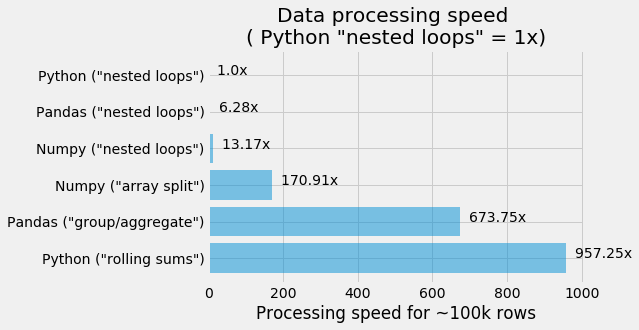

In [17]:
plt.style.use('fivethirtyeight')
objects = [x[0] for x in running_time]
y_rng = np.arange(len(objects))
performance = [base_time_1x/x[1] for x in running_time]
plt.barh(y_rng, performance, align='center', alpha=0.5)
plt.yticks(y_rng, objects)
plt.xlabel('Processing speed for ~100k rows')
plt.title('Data processing speed \n( Python "nested loops" = 1x)')
for a,b in zip(performance, y_rng):
    plt.text(a, b, "  "+str(round(a,2))+"x")
plt.show()